In [1]:
from carball.decompile_replays import analyze_replay_file

analysis9 = analyze_replay_file("carball/tests/replays/9-BUMPS.replay")
analysis3 = analyze_replay_file("carball/tests/replays/3-BUMPS.replay")
analysis0 = analyze_replay_file("carball/tests/replays/0-BUMPS.replay")
analysisM = analyze_replay_file("carball/tests/replays/MANY_BUMPS.replay")

['rattletrap-6.3.1-linux', 'rattletrap-6.3.1-osx', 'rattletrap-6.3.1-windows.exe']


Could not find field_of_view in camera settings for Goose
Could not find height in camera settings for Goose
Could not find pitch in camera settings for Goose
Could not find distance in camera settings for Goose
Could not find stiffness in camera settings for Goose
Could not find swivel_speed in camera settings for Goose
Could not find transition_speed in camera settings for Goose
Dropping these columns[('Goose', 'handbrake'), ('Goose', 'ball_cam'), ('Goose', 'ping'), ('Voices', 'ping'), ('game', 'is_overtime')]


['rattletrap-6.3.1-linux', 'rattletrap-6.3.1-osx', 'rattletrap-6.3.1-windows.exe']


Could not find field_of_view in camera settings for Imp
Could not find height in camera settings for Imp
Could not find pitch in camera settings for Imp
Could not find distance in camera settings for Imp
Could not find stiffness in camera settings for Imp
Could not find swivel_speed in camera settings for Imp
Could not find transition_speed in camera settings for Imp
Dropping these columns[('Imp', 'ping'), ('Imp', 'handbrake'), ('Imp', 'ball_cam'), ('Voices', 'ping'), ('game', 'is_overtime')]


['rattletrap-6.3.1-linux', 'rattletrap-6.3.1-osx', 'rattletrap-6.3.1-windows.exe']


Player Boomer as player has no MatchScore.
Could not find field_of_view in camera settings for Boomer
Could not find height in camera settings for Boomer
Could not find pitch in camera settings for Boomer
Could not find distance in camera settings for Boomer
Could not find stiffness in camera settings for Boomer
Could not find swivel_speed in camera settings for Boomer
Could not find transition_speed in camera settings for Boomer
Dropping these columns[('Boomer', 'handbrake'), ('Boomer', 'ball_cam'), ('Boomer', 'ping'), ('Voices', 'ping'), ('game', 'is_overtime')]


['rattletrap-6.3.1-linux', 'rattletrap-6.3.1-osx', 'rattletrap-6.3.1-windows.exe']


Dropping these columns[('game', 'is_overtime')]


In [2]:
import numpy as np

buffer = 150
z_buffer = 50
frame_buffer = 60

def angle_between(v1, v2):
    def unit_vector(vect):
         return vect / np.linalg.norm(vect)
    if np.linalg.norm(v1) == 0 or np.linalg.norm(v2) == 0:
        return 0
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def check_bumps(orange, blue, frame, bumps_found, bump_occur):
    '''
    Check bumps between two sets of teams 
    :param orange:
    :param blue:
    :param frame:
    :param bumps_found:
    :param bump_occur:
    '''
    for o in orange:
        for b in blue:
            o_name = o[1]
            b_name = b[1]
            o_stat = o[0]
            b_stat = b[0]
            attacker = None
            victim = None
            
            # if each coordinate is within a collision buffer
            x_close = abs(o_stat['pos_x'] - b_stat['pos_x']) < buffer
            y_close = abs(o_stat['pos_y'] - b_stat['pos_y']) < buffer
            z_close = abs(o_stat['pos_z'] - b_stat['pos_z']) < z_buffer
            if x_close and y_close and z_close:
                # for each car in the collision, calculate relative vector to bump
                o_bump_vector = np.array([b_stat['pos_x']-o_stat['pos_x'],b_stat['pos_y']-o_stat['pos_y']])
                b_bump_vector = -1 * o_bump_vector
                # for each car in the collision, calculate velocity vector
                o_vel_vector = np.array([o_stat['vel_x'],o_stat['vel_y']])
                b_vel_vector = np.array([b_stat['vel_x'],b_stat['vel_y']])
                # get angle between bump vector and velocity vector for each car
                o_angle = angle_between(o_vel_vector, o_bump_vector)
                b_angle = angle_between(b_vel_vector, b_bump_vector)
                # if head-on collision, car with greater velocity is attacker
                #print("{0}f: {1}".format(frame, abs(o_angle-b_angle)))
                if abs(o_angle-b_angle) < 0.8:
                    if np.linalg.norm(o_vel_vector) > np.linalg.norm(b_vel_vector):
                        attacker = o_name
                        victim = b_name
                    else:
                        attacker = b_name
                        victim = o_name
                # not head-on collision, sharper angle is attacker
                else:
                    if o_angle < b_angle:
                        attacker = o_name
                        victim = b_name
                    else:
                        attacker = b_name
                        victim = o_name
                # ignore bump if o bumped b within the past few frames
                if (attacker, victim) not in bump_occur or bump_occur[(attacker, victim)] < f - frame_buffer:              
                    bumps_found.append((attacker,victim,f))
                bump_occur[(attacker, victim)] = f

for analysis in [analysisM]:
    p = analysis.protobuf_game
    orange = list(filter(lambda x: x.is_orange,p.players))
    blue = list(filter(lambda x: not x.is_orange,p.players))
    orange_names = list(map(lambda x: x.name,orange))
    blue_names = list(map(lambda x: x.name,blue))

    frames = len(analysis.get_data_frames(analysis.game))
    a = analysis.get_data_frames(analysis.game)
    previous_bump = {} #last known frame of attacker on victim
    bumps_found = [] #(attacker, victim, frame) 
    for f in range(frames):
        orange_coordinates = list(map(lambda x: (a[x].iloc[f][['pos_x','pos_y','pos_z','vel_x','vel_y']], x), orange_names))
        blue_coordinates = list(map(lambda x: (a[x].iloc[f][['pos_x','pos_y','pos_z','vel_x','vel_y']], x), blue_names))
        check_bumps(orange_coordinates, blue_coordinates, f, bumps_found, previous_bump)
    for b in bumps_found:
        f = b[2]
        elapsed = a.game.iloc[f]['seconds_remaining']
        minutes = int(elapsed / 60)
        seconds = elapsed % 60
        print("{0} bumped {1} at {2}:{3} {4}".format(b[0], b[1], minutes, seconds, f))
    print("\n")

Voices bumped sanguineSwish at 4:56 246
sanguineSwish bumped Voices at 4:49 387
sanguineSwish bumped Voices at 4:29 759
sanguineSwish bumped Voices at 4:15 1014
Voices bumped sanguineSwish at 3:42 1630
sanguineSwish bumped Voices at 3:31 1827




In [63]:
print(analysisM.data_frame.sanguineSwish[2000:2050][["rot_x", "rot_y","rot_z", "vel_x", "vel_y", "ang_vel_x", "ang_vel_y", "ang_vel_z"]])

         rot_x     rot_y     rot_z  vel_x  vel_y  ang_vel_x  ang_vel_y  \
2001  0.009637 -1.533626  0.000011    0.0    0.1        0.0        0.1   
2002  0.009637 -1.533626  0.000011    0.0    0.1        0.0        0.1   
2003       NaN       NaN       NaN    NaN    NaN        NaN        NaN   
2004       NaN       NaN       NaN    NaN    NaN        NaN        NaN   
2005       NaN       NaN       NaN    NaN    NaN        NaN        NaN   
2006       NaN       NaN       NaN    NaN    NaN        NaN        NaN   
2007       NaN       NaN       NaN    NaN    NaN        NaN        NaN   
2008       NaN       NaN       NaN    NaN    NaN        NaN        NaN   
2009       NaN       NaN       NaN    NaN    NaN        NaN        NaN   
2010       NaN       NaN       NaN    NaN    NaN        NaN        NaN   
2011       NaN       NaN       NaN    NaN    NaN        NaN        NaN   
2012       NaN       NaN       NaN    NaN    NaN        NaN        NaN   
2013       NaN       NaN       NaN    

In [92]:
df = analysisM.data_frame.sanguineSwish.copy()
first = df[['vel_x', 'vel_y', 'vel_z','ang_vel_x', 'ang_vel_y', 'ang_vel_z']][0:-1].values
second = df[['vel_x', 'vel_y', 'vel_z','ang_vel_x', 'ang_vel_y', 'ang_vel_z']][1:].values
df['acc_x'] = 0
df['acc_y'] = 0
df['acc_z'] = 0
df['ang_acc_x'] = 0
df['ang_acc_y'] = 0
df['ang_acc_z'] = 0

df.loc[2:,['acc_x', 'acc_y', 'acc_z','ang_acc_x', 'ang_acc_y', 'ang_acc_z']] = second-first

df2 = analysisM.data_frame.Voices.copy()
first = df2[['vel_x', 'vel_y', 'vel_z','ang_vel_x', 'ang_vel_y', 'ang_vel_z']][0:-1].values
second = df2[['vel_x', 'vel_y', 'vel_z','ang_vel_x', 'ang_vel_y', 'ang_vel_z']][1:].values
df2['acc_x'] = 0
df2['acc_y'] = 0
df2['acc_z'] = 0
df2['ang_acc_x'] = 0
df2['ang_acc_y'] = 0
df2['ang_acc_z'] = 0

df2.loc[2:,['acc_x', 'acc_y', 'acc_z','ang_acc_x', 'ang_acc_y', 'ang_acc_z']] = second-first


4:49
4:33
4:32
4:17
4:7
4:4
3:42
3:34
3:27
3:27
3:10
2:59
2:55
2:54
2:50
2:42
2:26


<IPython.core.display.Javascript object>


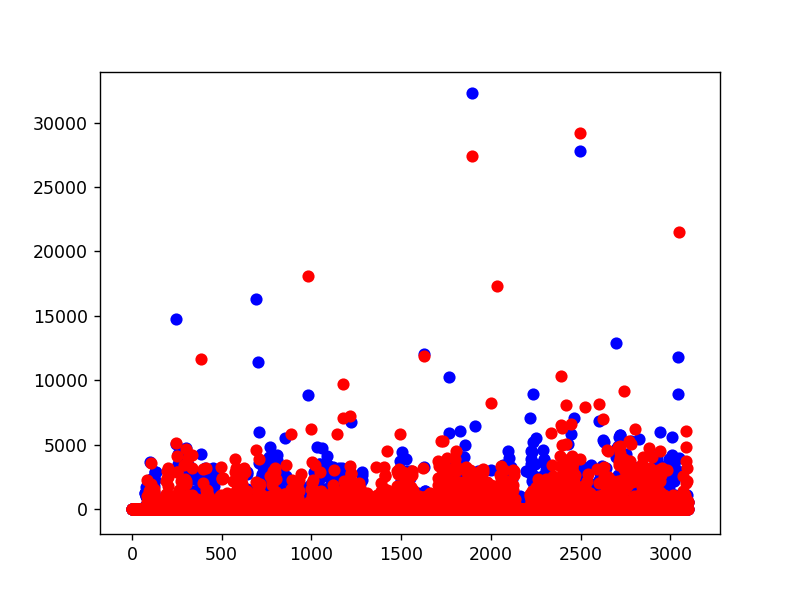

In [117]:
import math
DETECT_BUMP_VICTIM = 7000
DETECT_BUMP_AGGRESSOR = 500

def frame_to_time(f):
    elapsed = a.game.iloc[f]['seconds_remaining']
    minutes = int(elapsed / 60)
    seconds = elapsed % 60
    return str(minutes) + ":" + str(seconds)

frames = []
acc_mag = []
frames2 = []
acc_mag2 = []
for i in range(len(df)):
    row = df.iloc[i]
    row2 = df2.iloc[i]
    acc = math.sqrt(row['acc_x']**2+row['acc_y']**2+row['acc_z']**2)
    acc2 = math.sqrt(row2['acc_x']**2+row2['acc_y']**2+row2['acc_z']**2)
    frames.append(i)
    frames2.append(i)
    acc_mag.append(acc)
    acc_mag2.append(acc2)
    if acc > DETECT_BUMP_VICTIM and acc2 > DETECT_BUMP_AGGRESSOR:
        print(frame_to_time(i))
    elif acc2 > DETECT_BUMP_VICTIM and acc > DETECT_BUMP_AGGRESSOR:
        print(frame_to_time(i))
    
%matplotlib notebook
import matplotlib.pyplot as plt
plt.scatter(frames, acc_mag, color='blue')
plt.scatter(frames2, acc_mag2, color='red')
plt.show()

In [111]:
elapsed = a.game.iloc[2220]['seconds_remaining']
minutes = int(elapsed / 60)
seconds = elapsed % 60
print(minutes)
print(seconds)

3
10
